# Math 148 Project: Predicting Apartment Rental Prices

## Data Upload

In [ ]:
from google.colab import drive


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv("no_nas_master_dataset.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'no_nas_master_dataset.csv'

## Distribution of Dollar Per Square Foot

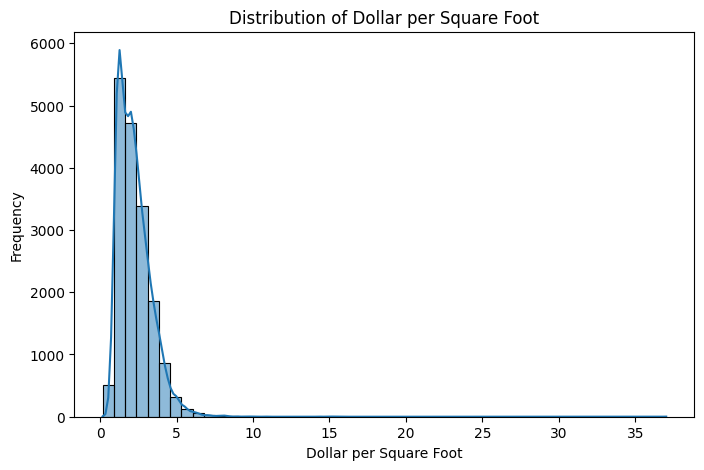

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["dollar_per_sq_ft"], bins=50, kde=True)
plt.xlabel("Dollar per Square Foot")
plt.ylabel("Frequency")
plt.title("Distribution of Dollar per Square Foot")
plt.show()

## Standardizing Columns and Features

In [ ]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'id', 'Civilian_labor_force_2022',
                          'Median_Household_Income_2021', 'category',
                          'price_per_income', 'square_feet',
                          'has_nan', 'price', 'total_income_amount'], inplace=True, errors="ignore")

In [ ]:
# Identify columns starting with "has_" or "allows_" (amenities)
has_columns = [col for col in df.columns if (col.startswith("has_") | col.startswith("allows_"))]

# Convert these columns to boolean
df[has_columns] = df[has_columns].astype(bool)

# Verify the conversion
df.dtypes

In [ ]:
# Define numerical and categorical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("dollar_per_sq_ft")
categorical_cols = df.select_dtypes(include=["object"]).columns

In [ ]:
# Define feature matrix X and target variable y
X = df.drop(columns=["dollar_per_sq_ft"])  # Features
y = df["dollar_per_sq_ft"]  # Target variable

# Standardize all numerical features in the entire dataset at once
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = encoder.fit_transform(X[categorical_cols])

# Combine transformed features
X_transformed = np.hstack((X[numerical_cols].values, X_cat))

# Convert back to DataFrame after transformation
X_transformed_df = pd.DataFrame(X_transformed, columns=list(numerical_cols) + encoder.get_feature_names_out(categorical_cols).tolist())

# Train-test split after transformation
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

## Ridge Regression

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)
alphas = np.linspace(0.01, 1000) # larger range of alphas tested
coeffs = []
training_r_squareds = []
validation_r_squareds = []
training_mses = []
validation_mses = []

for a in alphas:
  ridge = Ridge(alpha=a)
  ridge.fit(X_train, y_train)

  # Coefficients of features
  coeffs.append(ridge.coef_)

  # Evaluate model using training and validation data
  training_r_squareds.append(round(ridge.score(X_train, y_train), 2))
  validation_r_squareds.append(round(ridge.score(X_validation, y_validation), 2))

  # Calculate Mean Squared Error
  training_mses.append(mean_squared_error(y_train, ridge.predict(X_train)))
  validation_mses.append(mean_squared_error(y_validation, ridge.predict(X_validation)))

alpha_analysis_df = pd.DataFrame({'alphas': alphas, 'coefficients': coeffs,
                                  'training_r_squareds': training_r_squareds,
                                  'validation_r_squareds': validation_r_squareds,
                                  'training_mses': training_mses,
                                  'validation_mses': validation_mses})

In [ ]:
largest_coeffs = []
for c in alpha_analysis_df['coefficients']:
  # Find the 15 largest coefficients for each alpha by sorting c
  # and then getting the last/largest 15 values' indices/feature numbers
  largest_coeffs.append(np.argsort(c)[-15:])

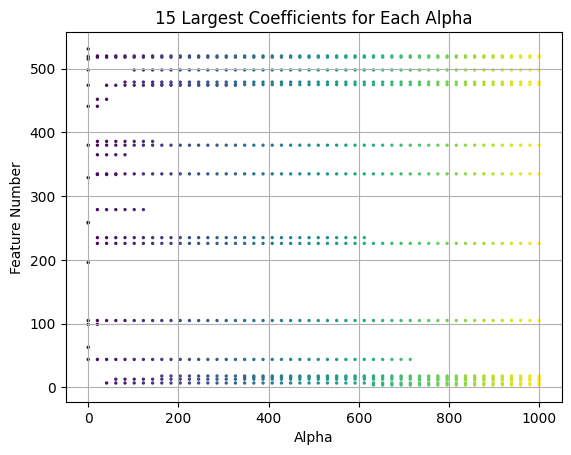

In [ ]:
# Plotting 15 largest coefficients for each alpha
x_values = np.repeat(alphas, 15)
plt.scatter(x_values, largest_coeffs, s = 2, c = x_values, cmap = plt.cm.viridis)
plt.xlabel('Alpha')
plt.ylabel('Feature Number')
plt.title('15 Largest Coefficients for Each Alpha')
plt.grid(axis = 'both') # showing both y and x axis gridlines
plt.show()

In [ ]:
# Gets the unique values and counts up the number of times each of those appear
# in combined_lc
unique_values, counts = np.unique(largest_coeffs, return_counts=True)

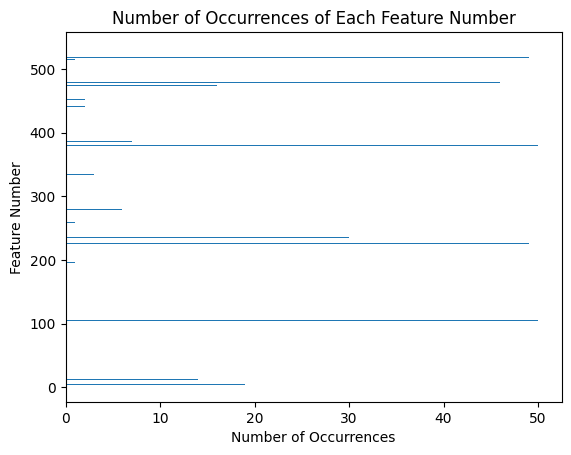

In [ ]:
# Want y-axis to be the unique indices that show up in combined_lc, and x to say
# how many times those unique numbers showed up
plt.barh(unique_values, counts)
plt.xlabel('Number of Occurrences')
plt.ylabel('Feature Number')
plt.title('Number of Occurrences of Each Feature Number')
plt.show()

In [ ]:
# Get the feature numbers for the largest 16 values that occurred the most often
# [across all alphas tested]
top_16_features = unique_values[np.argsort(counts)[-16:]]
top_16_features

array([  4, 235,  16,  44,  18, 475, 479, 498,  13,   7, 335, 226, 518,
       520, 105, 380])

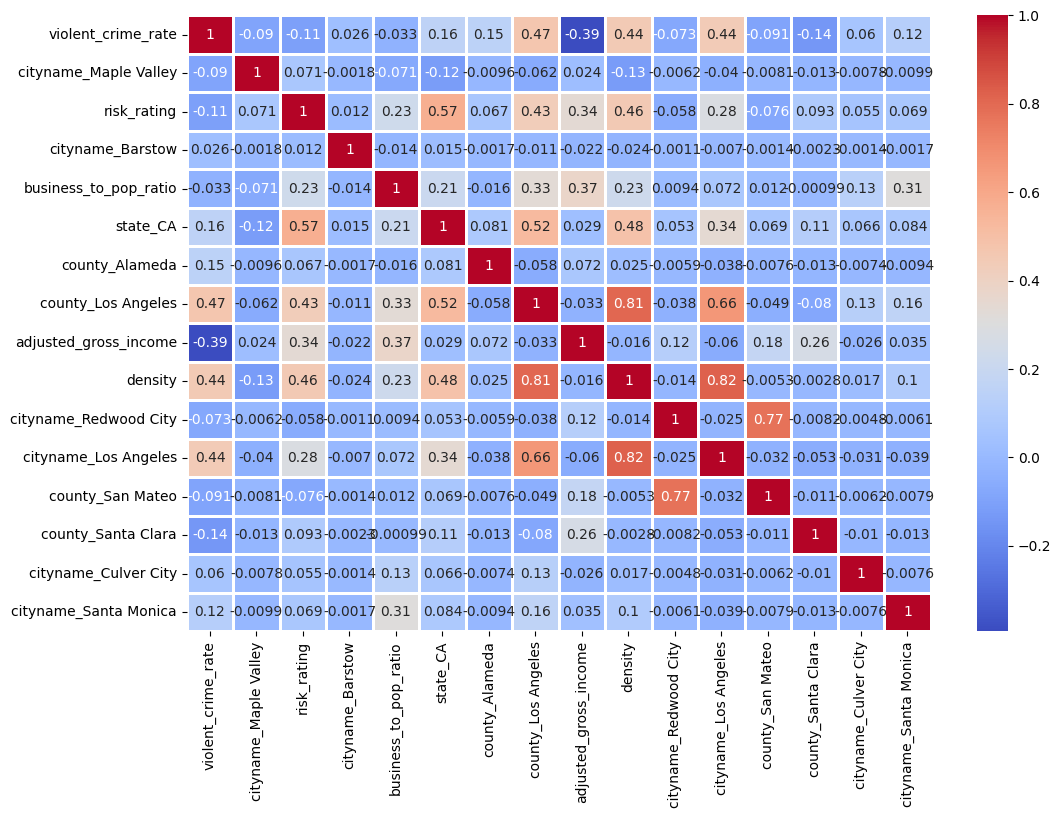

In [ ]:
import seaborn as sns

# Visualizing the correlation to see if more features need to be dropped
kept_features_X_train = X_train.iloc[:, top_16_features]
kept_features_X_validation = X_validation.iloc[:, top_16_features]
kept_features_X_test = X_test.iloc[:, top_16_features]

corr_matrix = kept_features_X_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.75, cmap='coolwarm')
plt.show()

In [ ]:
print('Smallest training MSE:', alpha_analysis_df.training_mses.min(),
      '\nSmallest validation MSE:', alpha_analysis_df.validation_mses.min())
print('Largest training R-squared:', alpha_analysis_df.training_r_squareds.max(),
      '\nLargest validation R-squared:', alpha_analysis_df.validation_r_squareds.max())

Smallest training MSE: 0.43989202782553366 
Smallest validation MSE: 0.3642343816928666
Largest training R-squared: 0.67 
Largest validation R-squared: 0.69


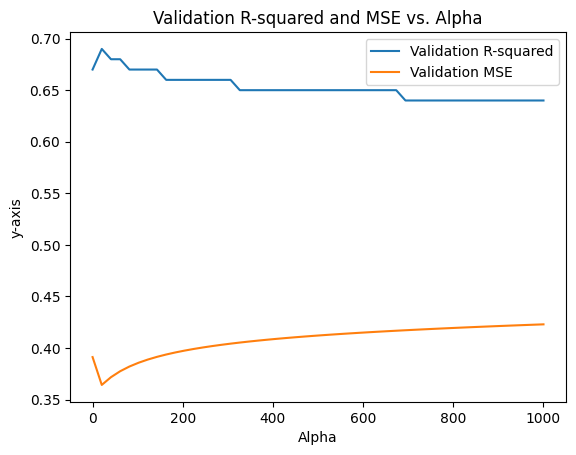

In [ ]:
fig, ax = plt.subplots()
# R-squared plot
ax.plot(alphas, alpha_analysis_df.validation_r_squareds,
        label='Validation R-squared')
# MSE plot
ax.plot(alphas, alpha_analysis_df.validation_mses,
        label='Validation MSE')

# Add labels and title
ax.set_xlabel('Alpha')
ax.set_ylabel('y-axis')
ax.set_title('Validation R-squared and MSE vs. Alpha')
# Add legend
ax.legend()

plt.show()

In [ ]:
best_alpha = alpha_analysis_df['alphas'][alpha_analysis_df.validation_r_squareds.idxmax()]
print('Alpha for smallest validation MSE and largest validation R-squared:', best_alpha)

Alpha for smallest validation MSE and largest validation R-squared: 20.41795918367347


In [ ]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(kept_features_X_train, y_train)

# Evaluate model
print("Ridge - R squared training set:", round(ridge.score(kept_features_X_train, y_train), 2))
print("Ridge - R squared validation set:", round(ridge.score(kept_features_X_validation, y_validation), 2))

# Calculate Mean Squared Error
mse_train_ridge = mean_squared_error(y_train, ridge.predict(kept_features_X_train))
mse_validation_ridge = mean_squared_error(y_validation, ridge.predict(kept_features_X_validation))
print("Ridge - MSE training set:", round(mse_train_ridge, 2))
print("Ridge - MSE validation set:", round(mse_validation_ridge, 2))

Ridge - R squared training set: 0.56
Ridge - R squared validation set: 0.61
Ridge - MSE training set: 0.59
Ridge - MSE validation set: 0.46


In [ ]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(kept_features_X_test, y_test)

# Evaluate model
print("Ridge - R squared testing set:", round(ridge.score(kept_features_X_test, y_test), 2))

# Calculate Mean Squared Error
mse_test_ridge = mean_squared_error(y_test, ridge.predict(kept_features_X_test))
print("Ridge - MSE testing set:", round(mse_test_ridge, 2))

Ridge - R squared testing set: 0.62
Ridge - MSE testing set: 0.43


## Lasso and Elastic Net Regression

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


In [ ]:
# Define hyperparameter distributions
lasso_params = {'alpha': uniform(0.001, 10)}

elastic_net_params = {
    'alpha': uniform(0.001, 10),  # Regularization strength
    'l1_ratio': uniform(0, 1)  # Mix between Lasso (1) and Ridge (0)
}

In [ ]:
# Lasso Regression with Random Search
lasso = Lasso(max_iter=5000)  # Ensure enough iterations for convergence
lasso_search = RandomizedSearchCV(lasso, lasso_params, n_iter=50, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)
lasso_search.fit(X_train, y_train)

# Elastic Net Regression with Random Search
elastic_net = ElasticNet(max_iter=5000)
elastic_net_search = RandomizedSearchCV(elastic_net, elastic_net_params, n_iter=50, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)
elastic_net_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ElasticNet(max_iter=5000), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aef7d1be950>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aef722e05d0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
print("Best Lasso Alpha:", lasso_search.best_params_['alpha'])
print("Best Lasso MSE:", -lasso_search.best_score_)

print("Best Elastic Net Alpha:", elastic_net_search.best_params_['alpha'])
print("Best Elastic Net L1 Ratio:", elastic_net_search.best_params_['l1_ratio'])
print("Best Elastic Net MSE:", -elastic_net_search.best_score_)

Best Lasso Alpha: 0.20684494295802447
Best Lasso MSE: 0.7557330929669192
Best Elastic Net Alpha: 0.2551912674409519
Best Elastic Net L1 Ratio: 0.10789142699330445
Best Elastic Net MSE: 0.6095552081305179


In [ ]:
# Train Lasso with best alpha
best_lasso = Lasso(alpha=lasso_search.best_params_['alpha'], max_iter=5000)
best_lasso.fit(X_train, y_train)

# Train Elastic Net with best alpha & l1_ratio
best_elastic_net = ElasticNet(alpha=elastic_net_search.best_params_['alpha'],
                              l1_ratio=elastic_net_search.best_params_['l1_ratio'],
                              max_iter=5000)
best_elastic_net.fit(X_train, y_train)

# Predictions
y_pred_lasso = best_lasso.predict(X_test)
y_pred_elastic_net = best_elastic_net.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Lasso Performance
print("Lasso Test MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso Test R2:", r2_score(y_test, y_pred_lasso))

# Elastic Net Performance
print("Elastic Net Test MSE:", mean_squared_error(y_test, y_pred_elastic_net))
print("Elastic Net Test R2:", r2_score(y_test, y_pred_elastic_net))


Lasso Test MSE: 0.5546211584330906
Lasso Test R2: 0.5056688007672867
Elastic Net Test MSE: 0.4234307763751867
Elastic Net Test R2: 0.6225981639991172


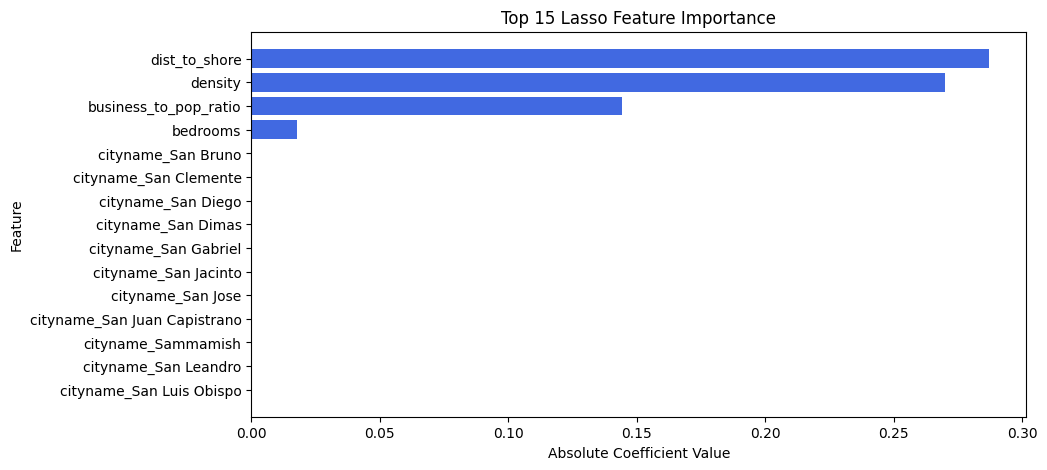

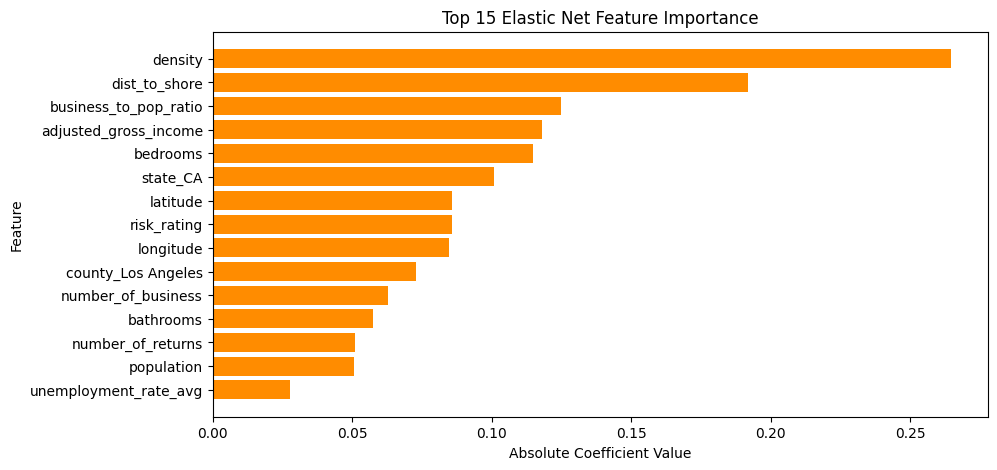

In [ ]:
# Get feature names
feature_names = X_train.columns  # Ensure X_train is a DataFrame

# Get absolute coefficient values
lasso_importance = np.abs(best_lasso.coef_)
elastic_net_importance = np.abs(best_elastic_net.coef_)

# Create DataFrame for plotting
lasso_df = pd.DataFrame({'Feature': feature_names, 'Importance': lasso_importance})
elastic_net_df = pd.DataFrame({'Feature': feature_names, 'Importance': elastic_net_importance})

# Sort by importance
lasso_df = lasso_df.sort_values(by='Importance', ascending=False)
elastic_net_df = elastic_net_df.sort_values(by='Importance', ascending=False)

# Plot Lasso Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(lasso_df['Feature'][:15], lasso_df['Importance'][:15], color='royalblue')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 15 Lasso Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

# Plot Elastic Net Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(elastic_net_df['Feature'][:15], elastic_net_df['Importance'][:15], color='darkorange')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 15 Elastic Net Feature Importance")
plt.gca().invert_yaxis()
plt.show()


## XGBoost and Random Forest

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("no_nas_master_dataset.csv")

# Drop unnecessary columns
df.drop(columns=["price_per_income", "price", "Unnamed: 0", "id", "category", "square_feet", "adjusted_gross_income"], inplace=True, errors="ignore")

In [ ]:
# Define numerical and categorical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("dollar_per_sq_ft")
categorical_cols = df.select_dtypes(include=["object"]).columns

# Train-test split
X = df.drop(columns=["dollar_per_sq_ft"])  # Features
y = df["dollar_per_sq_ft"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Combine transformed features
X_train_transformed = np.hstack((X_train_num, X_train_cat))
X_test_transformed = np.hstack((X_test_num, X_test_cat))

In [ ]:
# Define models
models = {
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, enable_categorical=True),
    "Random Forest": RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
}

# Store evaluation metrics
mse_scores = {}
r2_scores = {}

for name, model in models.items():
    # Train model
    model.fit(X_train_transformed, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test_transformed)
    mse_scores[name] = mean_squared_error(y_test, y_pred)
    r2_scores[name] = r2_score(y_test, y_pred)

In [ ]:
# Print MSE and R² values
mse_scores, r2_scores

({'XGBoost': 0.24065424534397195, 'Random Forest': 0.25939485878939444},
 {'XGBoost': 0.7855060163275741, 'Random Forest': 0.7688025967447274})

#### Feature Importance

In [ ]:
# Get numerical feature names
num_feature_names = numerical_cols.tolist()

# Get categorical feature names from the one-hot encoder
cat_feature_names = encoder.get_feature_names_out(categorical_cols).tolist()

# Combine both
feature_names = num_feature_names + cat_feature_names


In [ ]:
import pandas as pd

# Get feature importances from both models
xgb_feature_importance = models["XGBoost"].feature_importances_
rf_feature_importance = models["Random Forest"].feature_importances_

# Create DataFrames for visualization
xgb_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": xgb_feature_importance})
rf_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": rf_feature_importance})

# Sort by importance
xgb_importance_df = xgb_importance_df.sort_values(by="Importance", ascending=False)
rf_importance_df = rf_importance_df.sort_values(by="Importance", ascending=False)

# Display the top features
print("Top 15 Features - XGBoost:\n", xgb_importance_df.head(15))
print("\nTop 15 Features - Random Forest:\n", rf_importance_df.head(15))


Top 15 Features - XGBoost:
                           Feature  Importance
12                  dist_to_shore    0.292396
8                         density    0.077686
51          business_to_pop_ratio    0.060635
17   Median_Household_Income_2021    0.050871
75               cityname_Barstow    0.047741
484                      state_CA    0.037461
5              violent_crime_rate    0.031554
25            has_Internet.Access    0.028017
352         cityname_Redwood City    0.022490
10            dist2_large_airport    0.018160
14            total_income_amount    0.012613
20                       avg_temp    0.011949
35                    has_Doorman    0.011921
308    cityname_Pacific Palisades    0.009897
16      Civilian_labor_force_2022    0.009480

Top 15 Features - Random Forest:
                          Feature  Importance
12                 dist_to_shore    0.393242
51         business_to_pop_ratio    0.070135
8                        density    0.069812
4                    

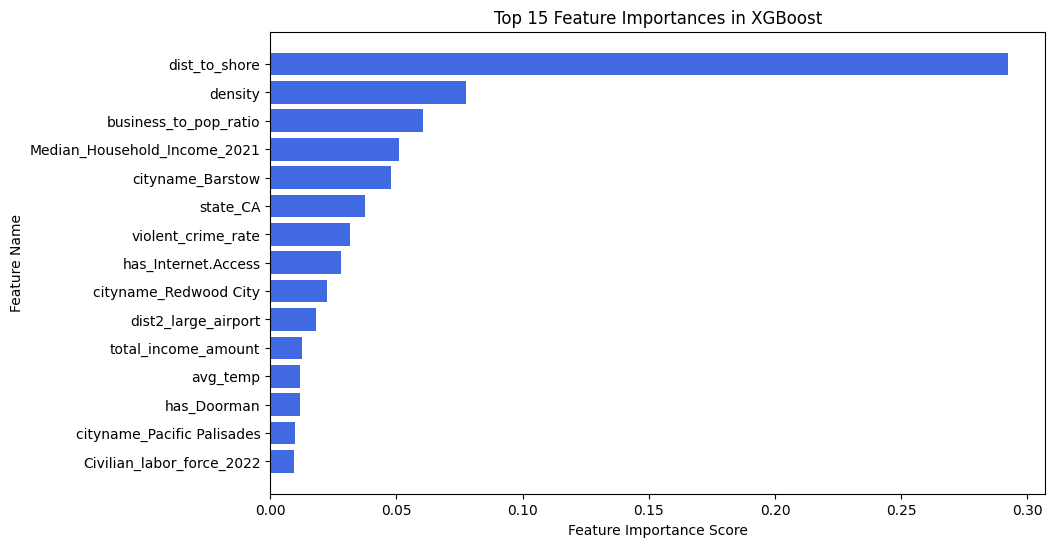

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df["Feature"][:15], xgb_importance_df["Importance"][:15], color="royalblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 15 Feature Importances in XGBoost")
plt.gca().invert_yaxis()  # Flip for better readability
plt.show()


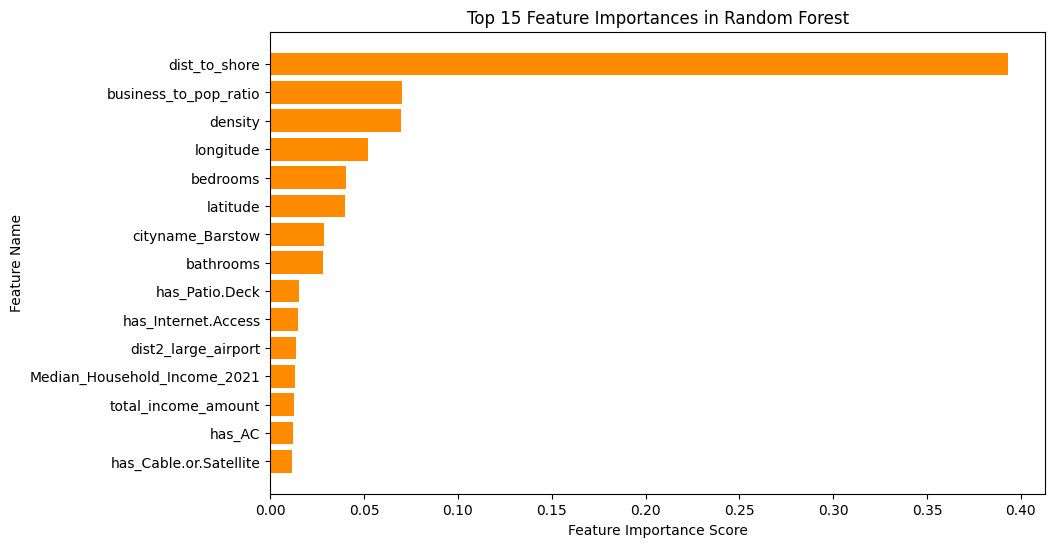

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df["Feature"][:15], rf_importance_df["Importance"][:15], color="darkorange")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 15 Feature Importances in Random Forest")
plt.gca().invert_yaxis()
plt.show()


### Random Forest Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize models
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_transformed, y_train)



Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Print best parameters
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

Best Random Forest Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
# Train models with best parameters
best_rf = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500,
                      n_jobs=-1, random_state=42)

In [ ]:
# Make predictions
y_pred_rf = best_rf.predict(X_test_transformed)

In [ ]:
mean_squared_error(y_test, y_pred_rf)

0.22747391113656262

In [ ]:
r2_score(y_test, y_pred_rf)

0.7972535854853106

### XGBoost Hyperparameter Tuning

In [ ]:
import xgboost as xgb

xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

dtrain = xgb.DMatrix(X_train_transformed, label=y_train)

cv_results = xgb.cv(
    xgb_params,
    dtrain,
    num_boost_round=100,
    nfold=3,
    metrics="rmse",
    as_pandas=True,
    seed=42
)

print(cv_results)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:32:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          1.096554        0.032574        1.098040       0.066365
1          1.062688        0.032480        1.065644       0.068206
2          1.030202        0.032392        1.035417       0.070071
3          0.999565        0.032526        1.006614       0.071616
4          0.970895        0.032686        0.980209       0.073362
..              ...             ...             ...            ...
95         0.485757        0.014291        0.677835       0.090463
96         0.485122        0.014248        0.677775       0.090568
97         0.484580        0.014313        0.678151       0.090609
98         0.484016        0.014392        0.678307       0.090918
99         0.483324        0.014345        0.678520       0.091021

[100 rows x 4 columns]


In [ ]:
import numpy as np

# Load the RMSE values from XGBoost CV
test_rmse = cv_results["test-rmse-mean"].values

# Compute the difference between consecutive test RMSE values
rmse_diff = np.abs(np.diff(test_rmse))

# Define a threshold where the RMSE change is considered "stable"
stability_threshold = 0.001  # You can adjust this threshold

# Find the first iteration where the RMSE change is below the threshold
stabilization_index = np.argmax(rmse_diff < stability_threshold)  # First occurrence

print(f"Test RMSE stabilizes around iteration {stabilization_index + 1}")

Test RMSE stabilizes around iteration 40


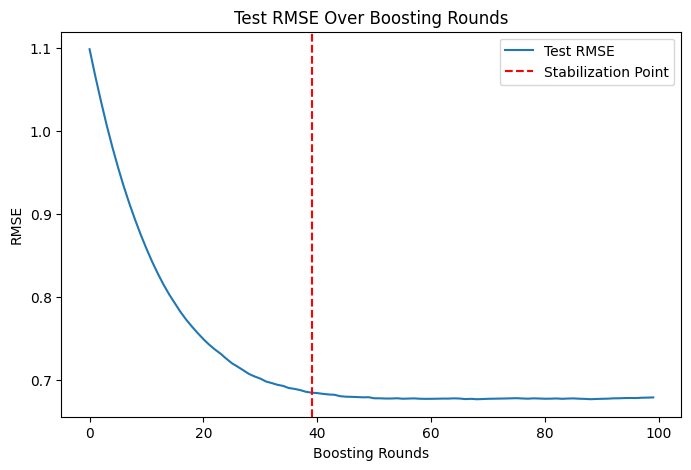

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(cv_results["test-rmse-mean"], label="Test RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Test RMSE Over Boosting Rounds")
plt.axvline(stabilization_index, color="red", linestyle="--", label="Stabilization Point")
plt.legend()
plt.show()

In [ ]:
best_n_estimators = stabilization_index
xgb_best = XGBRegressor(n_estimators=best_n_estimators, learning_rate=0.05, max_depth=6, objective='reg:squarederror', random_state=42)
xgb_best.fit(X_train_transformed, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=39, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb_best = xgb_best.predict(X_test_transformed)

from sklearn.metrics import mean_squared_error, r2_score

mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

print(f"XGBoost Best Model Test MSE: {mse_xgb_best:.4f}")
print(f"XGBoost Best Model Test R²: {r2_xgb_best:.4f}")


XGBoost Best Model Test MSE: 0.2928
XGBoost Best Model Test R²: 0.7390


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500, 700],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 1],  # L1 regularization
    "reg_lambda": [0, 0.01, 0.1, 1],  # L2 regularization
}

# Instantiate model
xgb_model = XGBRegressor(enable_categorical=True)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of different settings to test
    scoring="neg_mean_squared_error",
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on transformed training data
random_search.fit(X_train_transformed, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 700, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [ ]:
# Train XGBoost with the best parameters found
best_xgb = XGBRegressor(**random_search.best_params_, enable_categorical=True)
best_xgb.fit(X_train_transformed, y_train)

# Predict and evaluate
y_pred_best = best_xgb.predict(X_test_transformed)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned XGBoost MSE: {mse_best}")
print(f"Tuned XGBoost R2 Score: {r2_best}")


Tuned XGBoost MSE: 0.23674201217451044
Tuned XGBoost R2 Score: 0.7889929711343501


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split test set into validation set (40% of test set)
X_test_split, X_val, y_test_split, y_val = train_test_split(X_test_transformed, y_test, test_size=0.4, random_state=123)

# Initialize Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed, y_train)

# Predictions for test set
y_pred_test = lin_reg.predict(X_test_split)
mae_test = mean_absolute_error(y_test_split, y_pred_test)
mse_test = mean_squared_error(y_test_split, y_pred_test)
r2_test = r2_score(y_test_split, y_pred_test)

print(f"Linear Regression Test Results:")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"R² Score: {r2_test:.4f}")

# Predictions for validation set
y_pred_val = lin_reg.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Linear Regression Validation Results:")
print(f"Mean Absolute Error (MAE): {mae_val:.4f}")
print(f"Mean Squared Error (MSE): {mse_val:.4f}")
print(f"R² Score: {r2_val:.4f}")

NameError: name 'train_test_split' is not defined

## SVR

SVR Test MSE: 0.3098
SVR Test R² Score: 0.7239


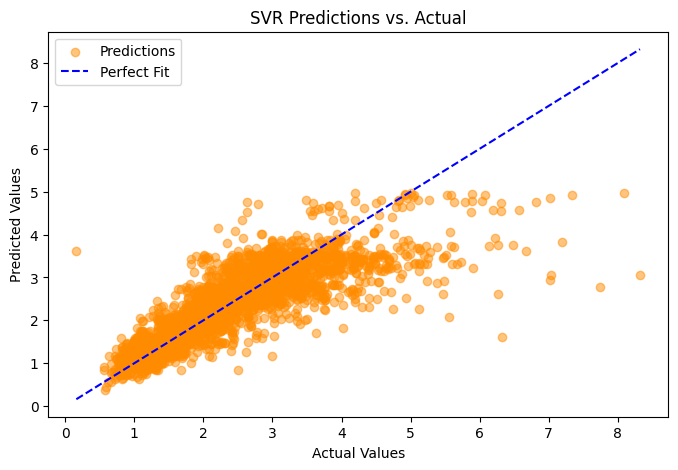

In [ ]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# Initialize SVR model
svr = SVR(kernel='linear')

# Train SVR model on transformed data
svr.fit(X_train_transformed, y_train)

# Predict on test data
y_pred_svr = svr.predict(X_test_transformed)

# Evaluate performance
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Test MSE: {mse_svr:.4f}")
print(f"SVR Test R² Score: {r2_svr:.4f}")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_svr, alpha=0.5, color="darkorange", label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="blue", label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR Predictions vs. Actual")
plt.legend()
plt.show()


# Comparison of All Models MSE and R-Squared

In [ ]:
# Retrieve MSE and R² from the initial XGBoost run
mse_xgb_initial = mse_scores["XGBoost"]  # From run before tuning
r2_xgb_initial = r2_scores["XGBoost"]

# Store model names, MSE, and R² scores
model_results = {
    "XGBoost": {"MSE": mse_xgb_initial, "R²": r2_xgb_initial},
    "Random Forest": {"MSE": mean_squared_error(y_test, y_pred_rf), "R²": r2_score(y_test, y_pred_rf)},
    "Ridge Regression": {"MSE": mse_test_ridge, "R²": ridge.score(kept_features_X_test, y_test)},
    "Lasso": {"MSE": mean_squared_error(y_test, y_pred_lasso), "R²": r2_score(y_test, y_pred_lasso)},
    "Elastic Net": {"MSE": mean_squared_error(y_test, y_pred_elastic_net), "R²": r2_score(y_test, y_pred_elastic_net)},
    "Linear Regression": {"MSE": mse_test, "R²": r2_test},
    "SVR": {"MSE": mse_svr, "R²": r2_svr}
}

# Convert to DataFrame for plotting
import pandas as pd
results_df = pd.DataFrame(model_results).T  # Transpose for readability

# Print results
print(results_df)


                        MSE        R²
XGBoost            0.240654  0.785506
Random Forest      0.227474  0.797254
Ridge Regression   0.425067  0.621140
Lasso              0.554621  0.505669
Elastic Net        0.423431  0.622598
Linear Regression  0.318812  0.716319
SVR                0.309781  0.723894


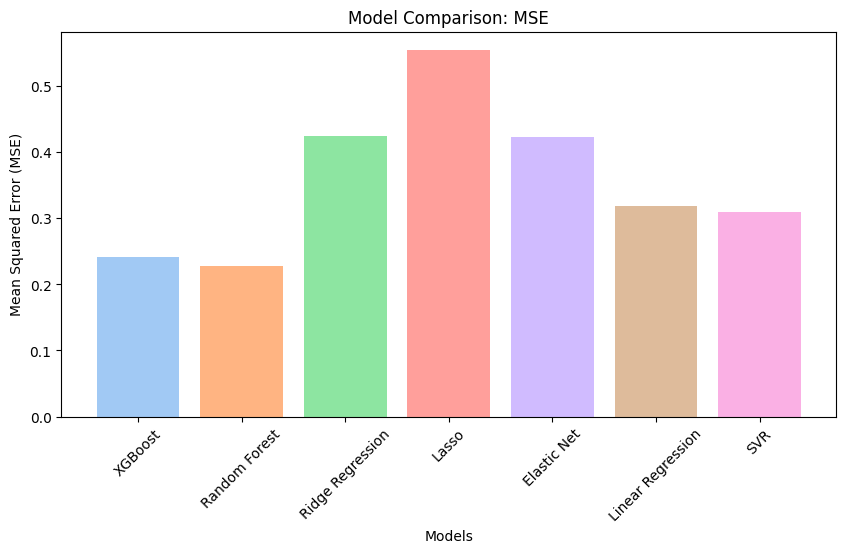

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn has nice pastel colors

# Use a pastel color palette
pastel_colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 5))
plt.bar(results_df.index, results_df["MSE"], color=pastel_colors)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Model Comparison: MSE")
plt.xticks(rotation=45)
plt.show()



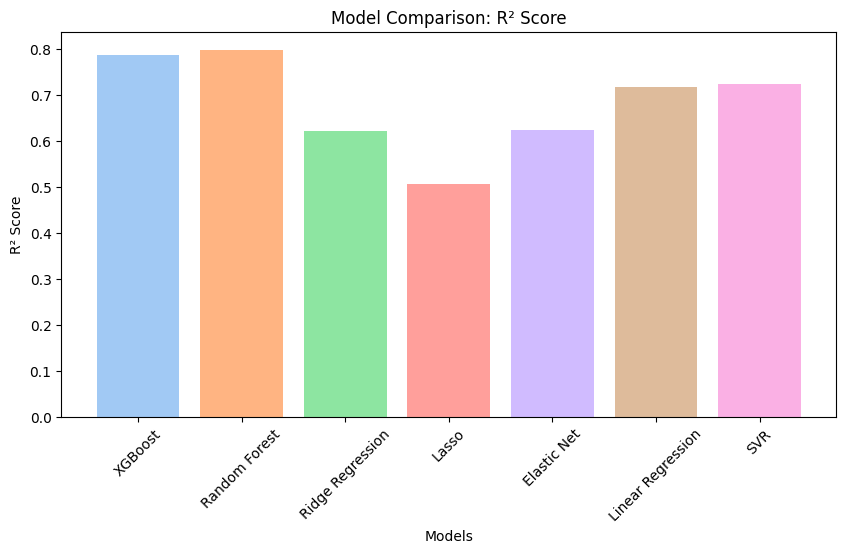

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn provides pastel colors

# Use a pastel color palette
pastel_colors = sns.color_palette("pastel")

plt.figure(figsize=(10, 5))
plt.bar(results_df.index, results_df["R²"], color=pastel_colors)
plt.xlabel("Models")
plt.ylabel("R² Score")
plt.title("Model Comparison: R² Score")
plt.xticks(rotation=45)
plt.show()


## Random Forest Model Without Outliers


In [ ]:
df = pd.read_csv("no_nas_master_dataset.csv")

# Drop unnecessary columns
df.drop(columns=["price_per_income", "price", "Unnamed: 0", "id", "category", "square_feet", "adjusted_gross_income"], inplace=True, errors="ignore")

In [ ]:
# Compute IQR for the target variable
Q1 = df["dollar_per_sq_ft"].quantile(0.25)
Q3 = df["dollar_per_sq_ft"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers

df_filtered = df[(df["dollar_per_sq_ft"] >= lower_bound) & (df["dollar_per_sq_ft"] <= upper_bound)]

In [ ]:
# Identify columns starting with "has_" or "allows_" (amenities)
has_columns = [col for col in df.columns if (col.startswith("has_") | col.startswith("allows_"))]

# Convert these columns to boolean
df[has_columns] = df[has_columns].astype(bool)

# Verify the conversion
df.dtypes

# Define numerical and categorical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop("dollar_per_sq_ft")
categorical_cols = df.select_dtypes(include=["object"]).columns

In [ ]:
# Define new feature matrix and target variable
X = df_filtered.drop(columns=["dollar_per_sq_ft"])
y = df_filtered["dollar_per_sq_ft"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize all numerical features in the entire dataset at once
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = encoder.fit_transform(X[categorical_cols])

# Combine transformed features
X_transformed = np.hstack((X[numerical_cols].values, X_cat))

# Convert back to DataFrame after transformation
X_transformed_df = pd.DataFrame(X_transformed, columns=list(numerical_cols) + encoder.get_feature_names_out(categorical_cols).tolist())

# Train-test split after transformation
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train Random Forest
rf_filtered = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_filtered.fit(X_train, y_train)

# Predict and evaluate
y_pred_filtered = rf_filtered.predict(X_test)

# Compute MSE and R²
mse_filtered = mean_squared_error(y_test, y_pred_filtered)
r2_filtered = r2_score(y_test, y_pred_filtered)

In [ ]:
print(f"Random Forest with Outliers Removed - MSE: {mse_filtered}")
print(f"Random Forest with Outliers Removed - R² Score: {r2_filtered}")

Random Forest with Outliers Removed - MSE: 0.1632399789303015
Random Forest with Outliers Removed - R² Score: 0.8126078677706661


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize models
rf_filtered = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(rf_filtered, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Print best parameters
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# Train models with best parameters
best_rf = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = best_rf.predict(X_test)

mean_squared_error(y_test, y_pred_rf)

r2_score(y_test, y_pred_rf)

Best Random Forest Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


0.8166440838115616

In [ ]:
# Get feature importances from both models
rf_feature_importance = models["Random Forest"].feature_importances_

# Create DataFrames for visualization
xgb_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": xgb_feature_importance})
rf_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": rf_feature_importance})

# Sort by importance
xgb_importance_df = xgb_importance_df.sort_values(by="Importance", ascending=False)
rf_importance_df = rf_importance_df.sort_values(by="Importance", ascending=False)

# Display the top features
print("Top 15 Features - XGBoost:\n", xgb_importance_df.head(15))
print("\nTop 15 Features - Random Forest:\n", rf_importance_df.head(15))

                          Feature  Importance
3                       longitude    0.086548
11                  dist_to_shore    0.062764
16   Median_Household_Income_2021    0.055604
7                         density    0.053841
17                     risk_score    0.052212
2                        latitude    0.051552
19                       avg_temp    0.048946
20          business_to_pop_ratio    0.040005
1                        bedrooms    0.038348
12             number_of_business    0.037599
15      Civilian_labor_force_2022    0.036163
5             property_crime_rate    0.035859
0                       bathrooms    0.034941
18                    risk_rating    0.031234
500            county_Los Angeles    0.031051
8                    dist_highway    0.029443
13            total_income_amount    0.026705
477                      state_CA    0.024875
21          unemployment_rate_avg    0.023982
4              violent_crime_rate    0.023307
9             dist2_large_airport 

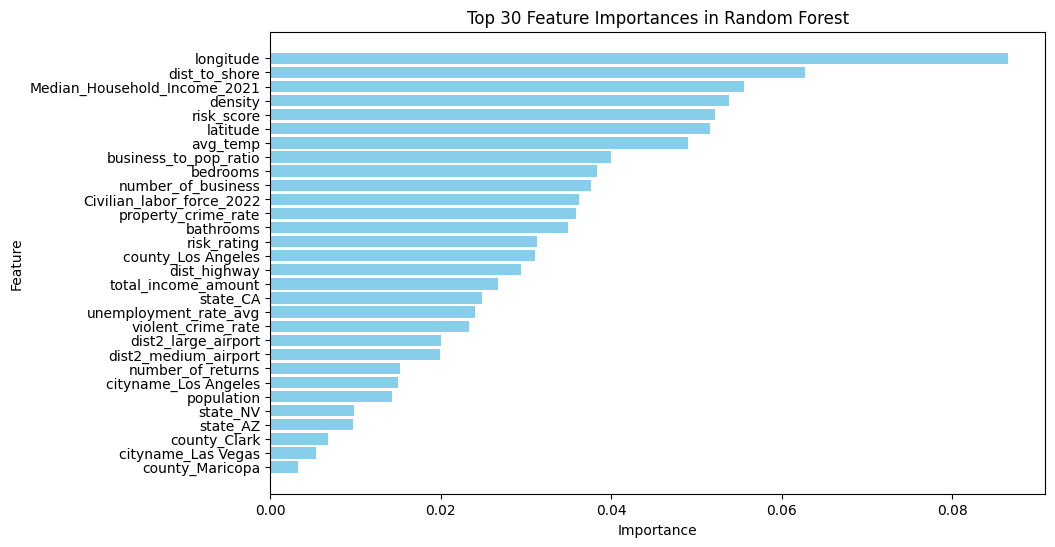

In [ ]:
# Get feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame and sort by importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(30)  # Select top 30

# Print top 30 feature importance values
print(feature_importance_df)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert axis for better readability
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances in Random Forest")
plt.show()

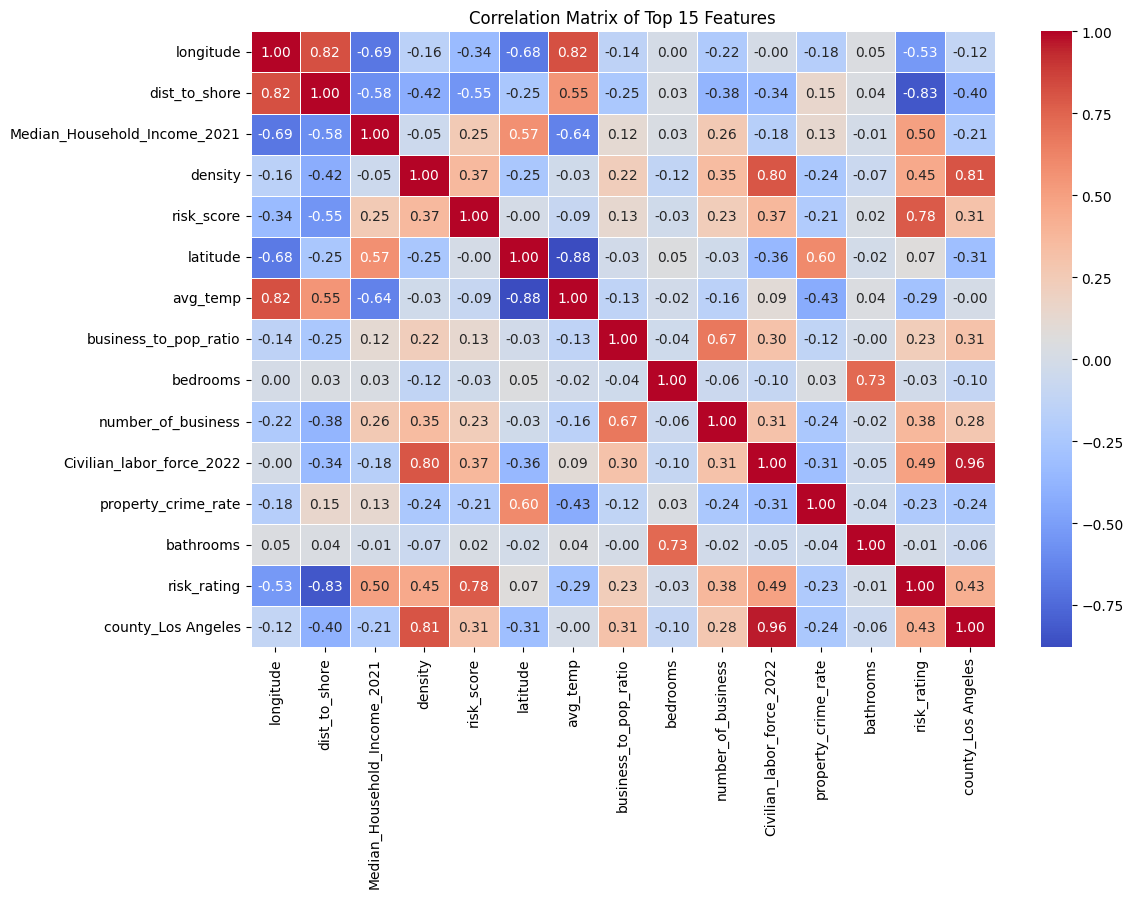

In [ ]:
# Create a DataFrame and sort by importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)  # Select top 15

# Extract top 15 feature names
top_15_features = feature_importance_df['Feature'].values

# Compute correlation matrix for top 15 features
correlation_matrix = X_train[top_15_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Top 15 Features")
plt.show()

## Removing Highly Correlated Variables

In [ ]:
# Set correlation threshold (adjust as needed)
correlation_threshold = 0.85

# Compute correlation matrix for all features
corr_matrix = X_train.corr().abs()

# Create an upper triangle matrix to avoid duplicate checks
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)

# Find highly correlated feature pairs
high_corr_pairs = (corr_matrix > correlation_threshold) & (upper_triangle == 1)

# Identify features to drop (keep the first occurrence)
features_to_drop = [column for column in high_corr_pairs.columns if any(high_corr_pairs[column])]

print("Features to drop due to high correlation:", features_to_drop)

# Drop highly correlated features from X_train and X_test
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

print(f"Reduced feature count: {X_train_reduced.shape[1]} (from {X_train.shape[1]})")

Features to drop due to high correlation: ['number_of_returns', 'avg_temp', 'state_NV', 'state_WA', 'county_Benton', 'county_Butte', 'county_Chelan', 'county_Clark', 'county_Cochise', 'county_Coconino', 'county_Deschutes', 'county_Fresno', 'county_Imperial', 'county_Josephine', 'county_Kern', 'county_King', 'county_Kitsap', 'county_Lane', 'county_Linn', 'county_Los Angeles', 'county_Madera', 'county_Marion', 'county_Merced', 'county_Napa', 'county_Pima', 'county_San Luis Obispo', 'county_Santa Cruz', 'county_Shasta', 'county_Sutter', 'county_Thurston', 'county_Walla Walla', 'county_Yakima', 'county_Yavapai', 'county_Yuma']
Reduced feature count: 505 (from 539)


In [ ]:
# Train models with best parameters
best_rf = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train_reduced, y_train)

# Make predictions
y_pred_rf = best_rf.predict(X_test_reduced)

mean_squared_error(y_test, y_pred_rf)

r2_score(y_test, y_pred_rf)

0.8160641391689907

                          Feature  Importance
3                       longitude    0.082665
11                  dist_to_shore    0.071986
15   Median_Household_Income_2021    0.066892
7                         density    0.059477
2                        latitude    0.055002
16                     risk_score    0.054758
18          business_to_pop_ratio    0.048762
14      Civilian_labor_force_2022    0.043179
8                    dist_highway    0.039666
12             number_of_business    0.039183
1                        bedrooms    0.037461
475                      state_CA    0.036797
5             property_crime_rate    0.035409
0                       bathrooms    0.035165
17                    risk_rating    0.034751


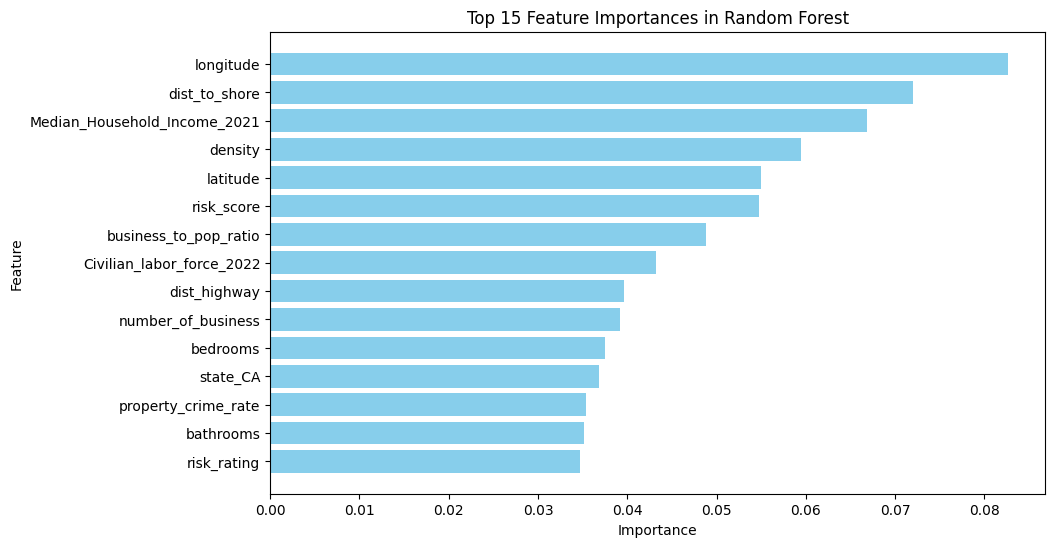

In [ ]:
# Get feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame and sort by importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)  # Select top 30

# Print top 30 feature importance values
print(feature_importance_df)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert axis for better readability
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importances in Random Forest")
plt.show()

Model Run with Only the Top Features

Top 10 Features - MSE: 0.2035, R²: 0.7664
Top 11 Features - MSE: 0.1697, R²: 0.8052
Top 12 Features - MSE: 0.1697, R²: 0.8051
Top 13 Features - MSE: 0.1700, R²: 0.8048
Top 14 Features - MSE: 0.1583, R²: 0.8183
Top 15 Features - MSE: 0.1584, R²: 0.8182
Top 20 Features - MSE: 0.1588, R²: 0.8177
Top 25 Features - MSE: 0.1589, R²: 0.8176
Top 30 Features - MSE: 0.1590, R²: 0.8174
Top 35 Features - MSE: 0.1590, R²: 0.8174
Top 40 Features - MSE: 0.1590, R²: 0.8174
Top 45 Features - MSE: 0.1590, R²: 0.8174
Top 50 Features - MSE: 0.1590, R²: 0.8174


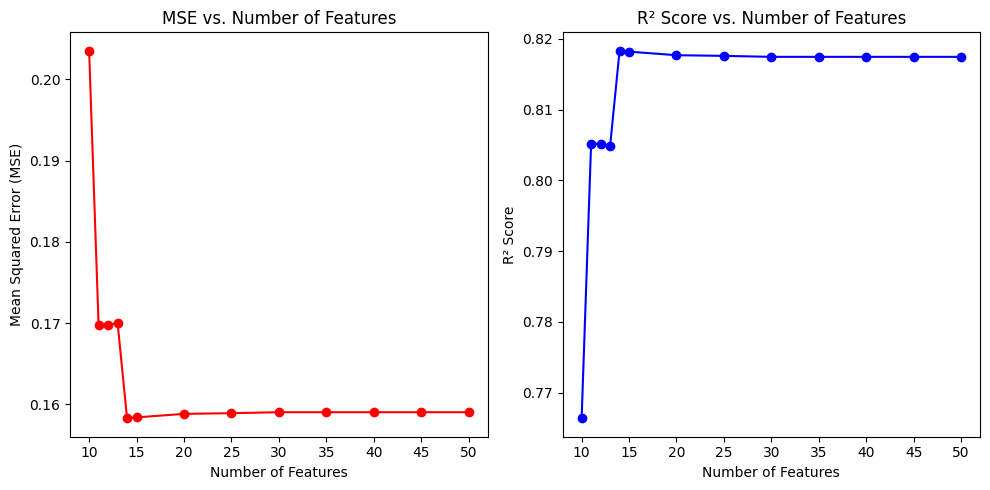

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define feature counts: 10, 11, 12, 13, 14, 15, then 20, 25, ..., 50
feature_counts = list(range(10, 16)) + list(range(20, 55, 5))

# Initialize lists to store MSE and R² values
mse_values = []
r2_values = []

# Loop through different feature counts
for n in feature_counts:
    # Select top n features
    top_n_features = feature_importance_df['Feature'].head(n).values

    # Filter X_train and X_test
    X_train_n = X_train_reduced[top_n_features]
    X_test_n = X_test_reduced[top_n_features]

    # Train Random Forest with top n features
    rf_model = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_n, y_train)

    # Make predictions
    y_pred_n = rf_model.predict(X_test_n)

    # Compute metrics
    mse = mean_squared_error(y_test, y_pred_n)
    r2 = r2_score(y_test, y_pred_n)

    # Store results
    mse_values.append(mse)
    r2_values.append(r2)

    print(f"Top {n} Features - MSE: {mse:.4f}, R²: {r2:.4f}")

# Plot MSE and R² vs. Feature Count
plt.figure(figsize=(10, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(feature_counts, mse_values, marker='o', linestyle='-', color='red')
plt.xlabel("Number of Features")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Number of Features")

# R² Score Plot
plt.subplot(1, 2, 2)
plt.plot(feature_counts, r2_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Features")
plt.ylabel("R² Score")
plt.title("R² Score vs. Number of Features")

plt.tight_layout()
plt.show()


In [ ]:
# Select top 14 features
top_14_features = feature_importance_df['Feature'].head(14).values

# Filter X_train and X_test
X_train_14 = X_train_reduced[top_14_features]
X_test_14 = X_test_reduced[top_14_features]

# Train Random Forest with top 14 features
rf_model_14 = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42, n_jobs=-1)
rf_model_14.fit(X_train_14, y_train)

# Make predictions
y_train_pred_14 = rf_model_14.predict(X_train_14)
y_pred_14 = rf_model_14.predict(X_test_14)

# Compute MSE
mse_train_14 = mean_squared_error(y_train, y_train_pred_14)
mse_test_14 = mean_squared_error(y_test, y_pred_14)

# Compute R²
r2_train_14 = r2_score(y_train, y_train_pred_14)
r2_test_14 = r2_score(y_test, y_pred_14)

print(f"Train MSE: {mse_train_14:.4f}, Test MSE: {mse_test_14:.4f}")
print(f"Train R²: {r2_train_14:.4f}, Test R²: {r2_test_14:.4f}")



Train MSE: 0.1097, Test MSE: 0.1583
Train R²: 0.8754, Test R²: 0.8183


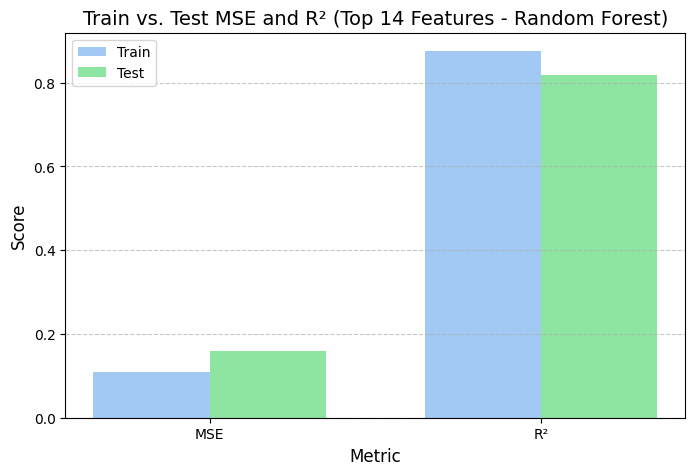

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a pastel color palette
pastel_colors = sns.color_palette("pastel")

# Define metrics and scores
metrics = ["MSE", "R²"]
train_scores = [mse_train_14, r2_train_14]
test_scores = [mse_test_14, r2_test_14]

x = range(len(metrics))

plt.figure(figsize=(8, 5))

# Adjust bar positions for spacing
bar_width = 0.35
plt.bar([i - bar_width/2 for i in x], train_scores, width=bar_width, label="Train", color=pastel_colors[0], edgecolor="black")
plt.bar([i + bar_width/2 for i in x], test_scores, width=bar_width, label="Test", color=pastel_colors[2], edgecolor="black")

# Customize appearance
plt.xticks(x, metrics)
plt.xlabel("Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Train vs. Test MSE and R² (Top 14 Features - Random Forest)", fontsize=14)
plt.legend()

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

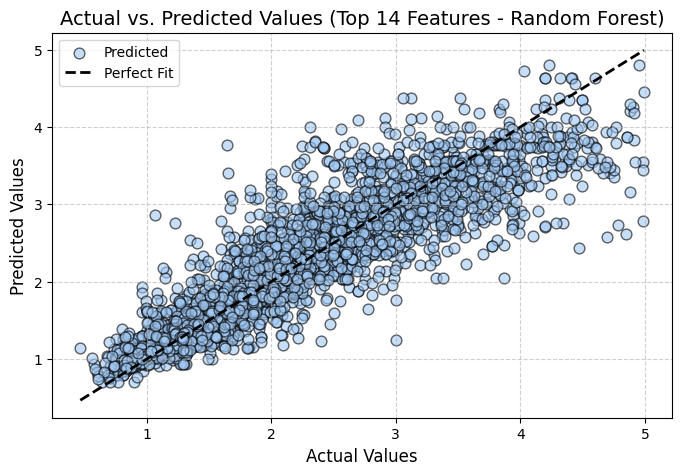

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's pastel color palette
pastel_colors = sns.color_palette("pastel")

plt.figure(figsize=(8, 5))

# Scatter plot with pastel blue color and larger markers
plt.scatter(y_test, y_pred_14, alpha=0.6, color=pastel_colors[0], edgecolor="black", s=60, label="Predicted")

# Perfect fit reference line (diagonal)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="black", linewidth=2, label="Perfect Fit")

# Labels and title
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.title("Actual vs. Predicted Values (Top 14 Features - Random Forest)", fontsize=14)

# Add grid for better readability
plt.grid(linestyle="--", alpha=0.6)

# Add legend
plt.legend()

# Show the plot
plt.show()
